# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [18]:
# load baselines: filename!!
with open('results/baselines_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.0,0.835500
1,0.001,0.001,-1,1,1.0,0.912000
2,0.001,0.001,-1,2,1.0,0.928333
3,0.001,0.001,-1,3,1.0,0.900167
4,0.001,0.001,-1,4,1.0,0.904722


In [12]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.000000,0.789556
1,0.001,0.001,-1,1,1.000000,0.798833
2,0.001,0.001,-1,2,0.933333,0.811389
3,0.001,0.001,-1,3,1.000000,0.800222
4,0.001,0.001,-1,4,1.000000,0.803500


In [59]:
df_empirical = df.copy()

In [11]:
df_empirical_random = df.copy()

In [62]:
df_truncate = df.copy()

In [ ]:
# OR LOAD ARI Scores
with open("results/ari_scores/ari_scores_finetuned.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

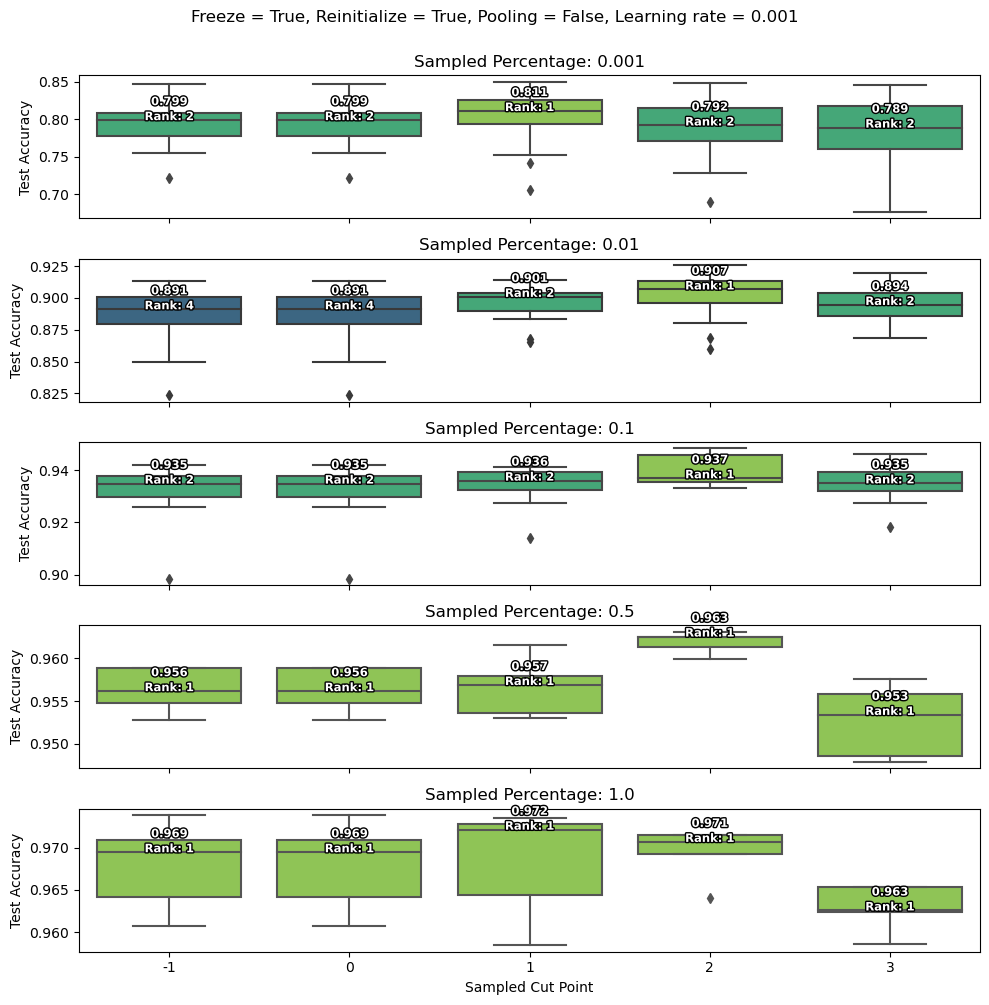

In [13]:
# run statistical tests below to get the df_rankings
_, df_rankings = pairwise_comparison(df=df)
box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

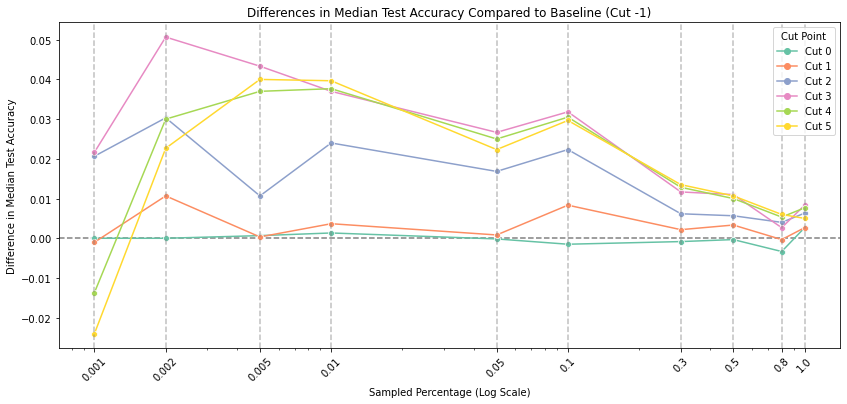

In [7]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

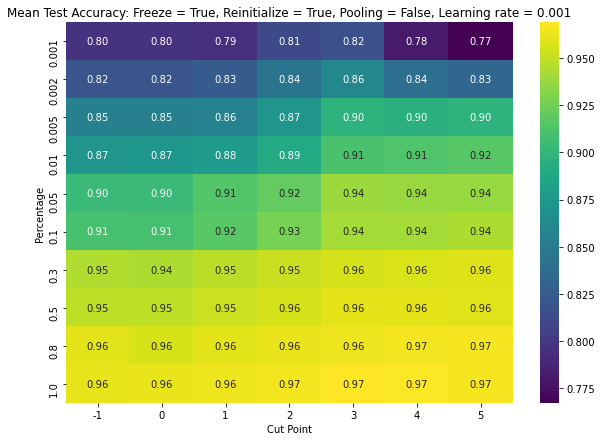

In [13]:
heatmap(df, params, figsize=(10,7))

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

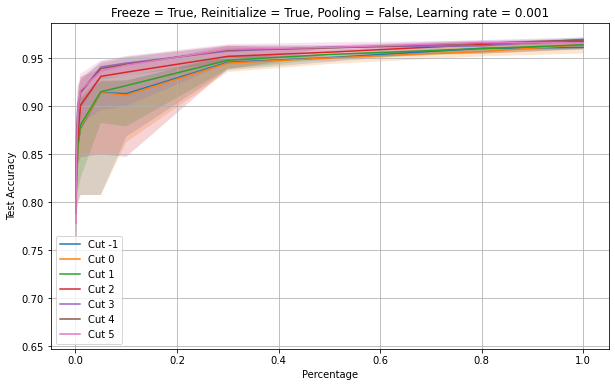

In [15]:
line_pilot_with_ranges(df, params)

### ARI Box Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

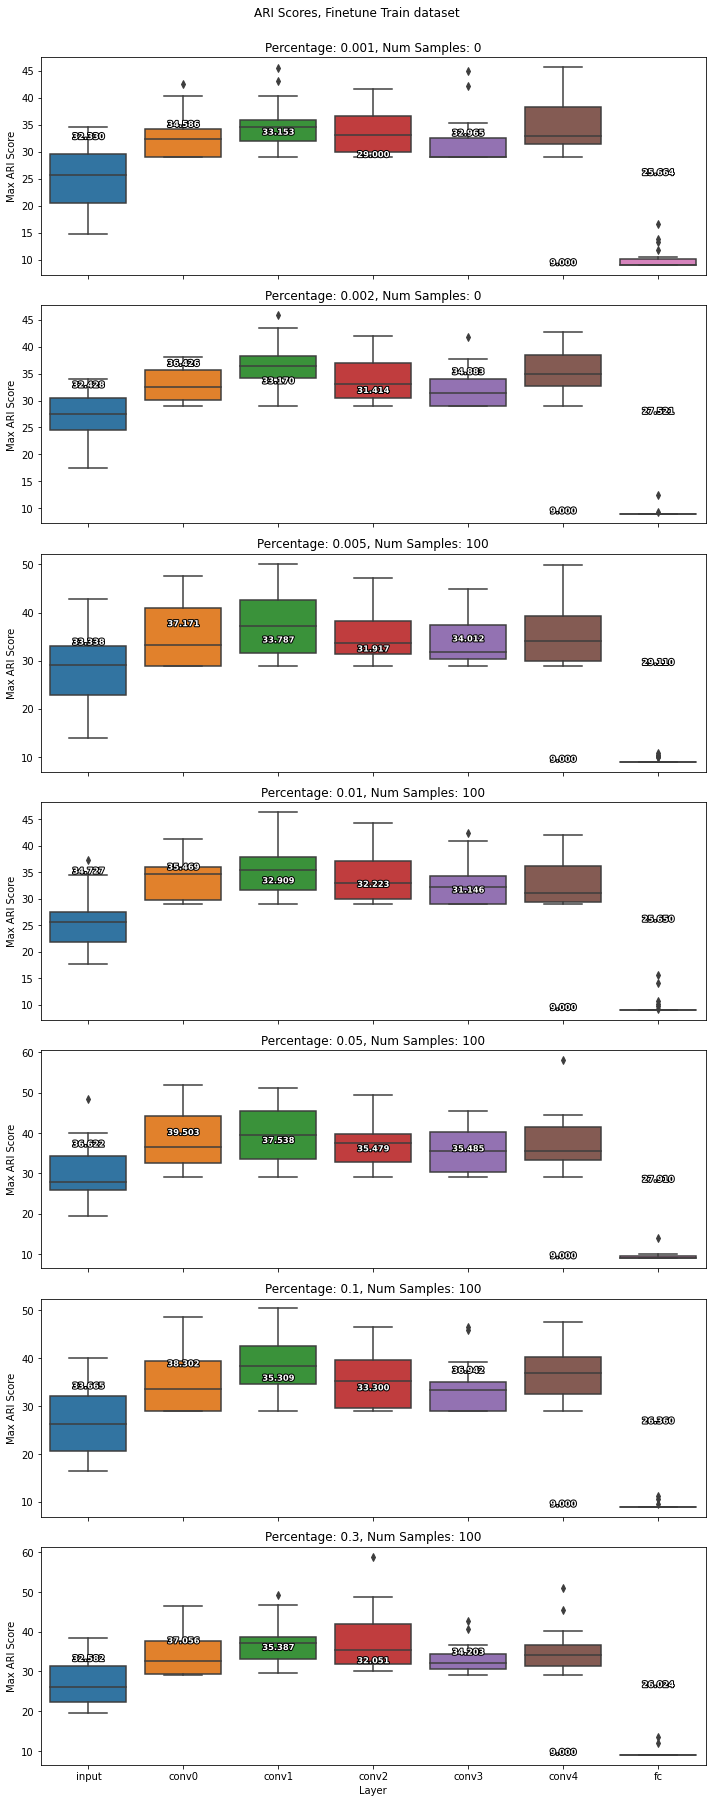

In [16]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores_percentages(df_ari, dataset="Finetune", split="Train", order=layer_names, figsize=(10,25))

# 2. Statistical Tests

### Pairwise Comparison between two plots

In [63]:
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_truncate)

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [64]:
stats_empirical = df_empirical.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_empirical = stats_empirical.reset_index()
stats_empirical.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

stats_truncate = df_truncate.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_truncate = stats_truncate.reset_index()
stats_truncate.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

In [65]:
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2

df_rankings_empirical = stats_empirical.copy()
df_rankings_truncate = stats_truncate.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > df_rankings_truncate.iloc[i]['Mean Test Accuracy']:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 8
            df_rankings_truncate.loc[i, 'Mean Test Accuracy'] = 1
        else:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 1
            df_rankings_truncate.loc[i, 'Mean Test Accuracy'] = 8
    else:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 5
        df_rankings_truncate.loc[i, 'Mean Test Accuracy'] = 5

df_rankings_empirical['rank'] = df_rankings_empirical['Mean Test Accuracy'].astype(int)
df_rankings_truncate['rank'] = df_rankings_truncate['Mean Test Accuracy'].astype(int)

{8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8}


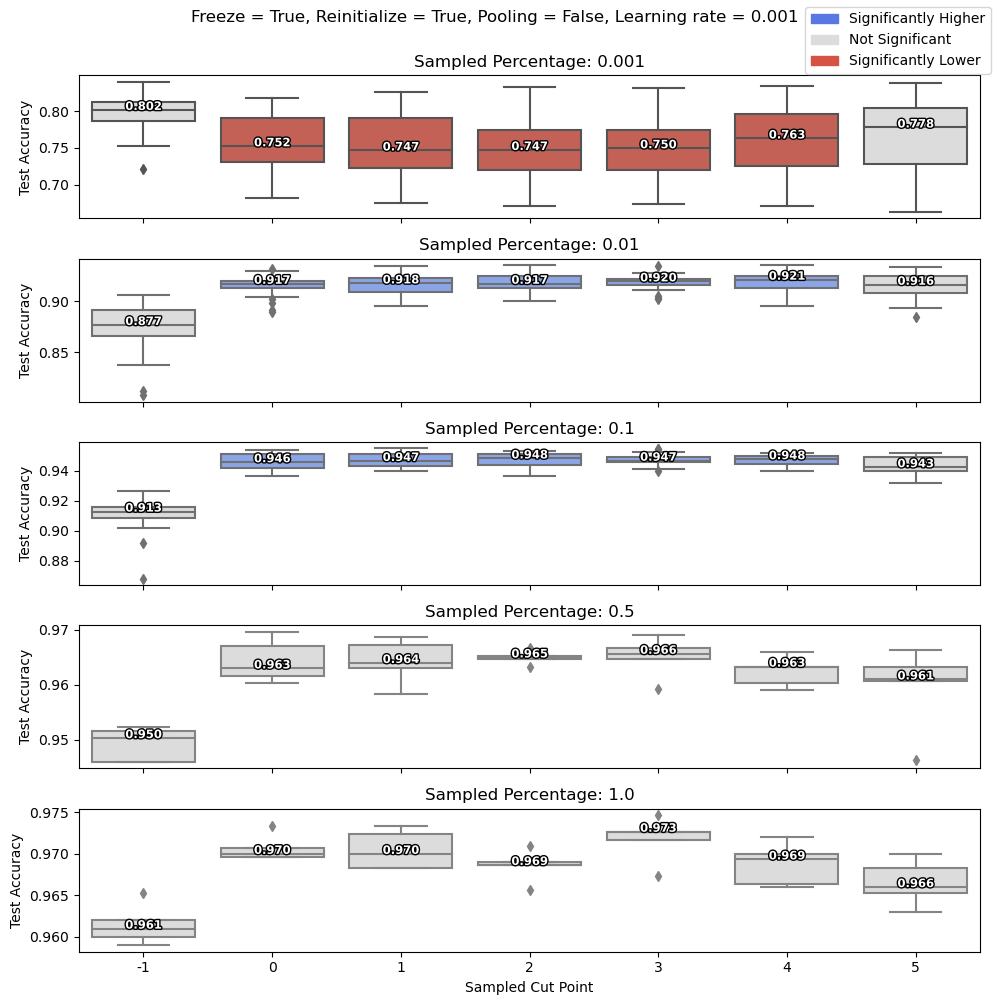

In [67]:
ranks_sorted = box_plot_percentages_experiments(df=df_empirical, rank_df=df_rankings_empirical, unique_ranks=np.array([1,5,8]), pairwise=True, color_palette="coolwarm", add_baseline=False, color_ranks=True, params=params)

{8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8}


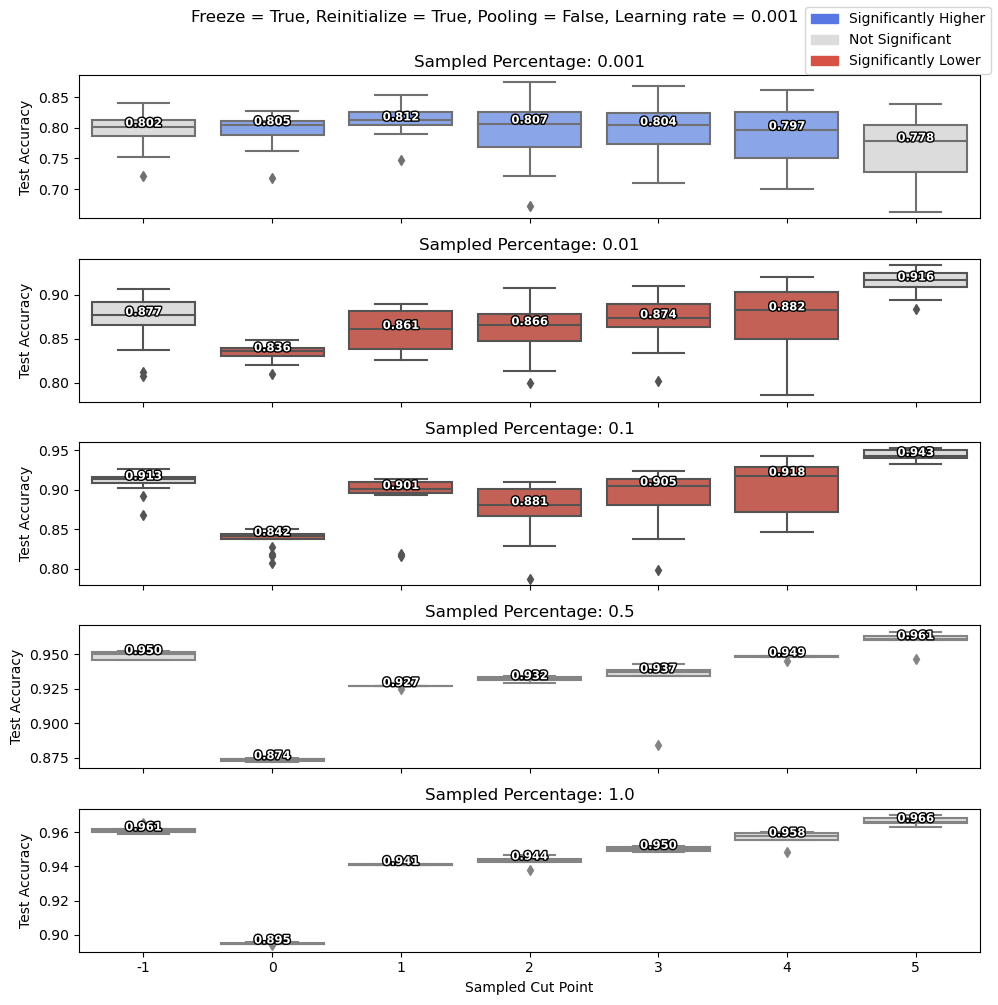

In [69]:
ranks_sorted = box_plot_percentages_experiments(df=df_truncate, rank_df=df_rankings_truncate, pairwise=True, unique_ranks=np.array([1,5,8]),  color_palette="coolwarm", add_baseline=False, color_ranks=True, params=params)

### Tables for Ranking Cuts

In [22]:
df_wilcoxon_pairwise, _ = pairwise_comparison(df=df)

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False)
# print(latex_table)
# TODO: next, \text{p-value if significant}
# iterate over both the rows in the latex table string and the df_wilcoxon_pairwise
# if the row is significant, add the p-value to the latex table string
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        # split row with respect to " & ", take the 5th value, encapsulate it in \textbf{} and join them back
        row = row.split(" & ")
        
        # row[4] = "\colorbox[HTML]{B2EAB1}{\\textbf{" + row[4].strip("\\") + "}}"
        # print(row)
        row = " & ".join(row[:-1])
        row = "\\rowcolor{green!20}\n" + row
    else:
        row = row.split(" & ")
        row = " & ".join(row[:-1])
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(header + rows + footer)

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [23]:
print(latex_table)

\begin{tabular}{rrrrrr}
\toprule
Percentage & Cut Point 1 & Cut Point 2 & statistic & p_value & is_significant \\
\midrule
\rowcolor{green!20}
0.001000 & 0 & 1 & 48 & 0.001296 \\
0.001000 & 0 & 2 & 155 & 0.853200 \\
0.001000 & 0 & 3 & 159 & 0.936803 \\
\rowcolor{green!20}
0.001000 & 1 & 2 & 62 & 0.005579 \\
\rowcolor{green!20}
0.001000 & 1 & 3 & 79 & 0.025505 \\
0.001000 & 2 & 3 & 155 & 0.853200 \\
0.010000 & 0 & 1 & 123 & 0.299612 \\
\rowcolor{green!20}
0.010000 & 0 & 2 & 71 & 0.012466 \\
\rowcolor{green!20}
0.010000 & 0 & 3 & 43 & 0.000715 \\
\rowcolor{green!20}
0.010000 & 1 & 2 & 75 & 0.017312 \\
\rowcolor{green!20}
0.010000 & 1 & 3 & 23 & 0.000038 \\
\rowcolor{green!20}
0.010000 & 2 & 3 & 1 & 0.000000 \\
0.100000 & 0 & 1 & 76 & 0.679037 \\
0.100000 & 0 & 2 & 90 & 0.621513 \\
\rowcolor{green!20}
0.100000 & 0 & 3 & 12 & 0.000835 \\
0.100000 & 1 & 2 & 95 & 0.728506 \\
\rowcolor{green!20}
0.100000 & 1 & 3 & 43 & 0.019234 \\
\rowcolor{green!20}
0.100000 & 2 & 3 & 7 & 0.000036 \\
0.50000

# 3. Extras
Don't forget to change the flags to the correct ones for the titles in the params!

### Extra 1: Split the dictionaries into baseline and fine-tuning one
only run when necessary

In [14]:
with open('results/results_freeze_True_reinit_True_pool_False_random_classes.json', 'r') as f:
    data_dicts = json.load(f)

params = data_dicts[0]
baselines = [params]
results = [params]
for row in data_dicts[1:]:
    if row["sampled_cut_point"] == -1:
        baselines.append(row)
    else:
        results.append(row)

with open(f'results/baselines_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'w') as f:
    json.dump(baselines, f)
with open(f'results/results_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'w') as f:
    json.dump(results, f)